<a href="https://colab.research.google.com/github/GGoYoungHee/COVID19-Classification/blob/main/Code/EfficientNet_fin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ls

drive/  sample_data/


In [ ]:
import numpy as np # linear algebra
import pandas as pd
import cv2
import matplotlib.pyplot as plt 
import seaborn as sns
import os
from PIL import Image
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.utils import load_img
from tensorflow.python.keras.utils import np_utils
# from keras.preprocessing.image import img_to_array
# from keras.preprocessing.image import load_img
# from keras.utils import np_utils

In [ ]:
DATASET_DIR = "/content/drive/MyDrive/VISION-covid_CT"
os.listdir(DATASET_DIR)

['CT_COVID.zip',
 'CT_NonCOVID.zip',
 'CT_COVID',
 '__MACOSX',
 'CT_NonCOVID',
 'COVID.ipynb',
 'EfficientNet.ipynb']

In [ ]:
##데이터 불러오기
COVID_data = os.listdir(DATASET_DIR+"/CT_COVID")
print(COVID_data[:10]) #the output we get are the .png files

NONCOVID_data=os.listdir(DATASET_DIR+"/CT_NonCOVID")
print(NONCOVID_data[:10])

['2020.03.26.20041426-p11-130.png', '2020.03.13.20035212-p23-154.png', '2020.02.27.20027557-p25-137%1.png', '2020.03.25.20037721-p27-174.png', '2020.03.01.20029769-p21-73_1%2.png', '2020.03.22.20040782-p24-1533-6.png', '2020.02.23.20026856-p17-115%5.png', '2020.02.13.20022673-p13-77%1.png', '2020.03.18.20038125-p15-54-5.png', '2020.02.22.20024927-p18-66%1.png']
['921.png', '663.png', '174.png', '1310.png', '709.png', '781.png', '782.png', '1702.png', '3.jpg', '7.jpg']


In [ ]:
minh=224
minv=224

# 데이터 셋 생성

In [ ]:
## COVID, NONCOVID 데이터에 대하여 각각 리스트 생성
## COVID, NONCOVID 전체 데이터 개수는 각각 349,397개로 총 746개이다.
COVID_list = []
for p in COVID_data:
    image = Image.open(DATASET_DIR+"/CT_COVID"+"/"+p)
    image = image.resize((minh, minv))
    image = image.convert(mode="RGB")
    COVID_list.append(image)
NONCOVID_list = []
for u in NONCOVID_data:
    image = Image.open(DATASET_DIR+"/CT_NonCOVID"+"/"+u)
    image = image.resize((minh, minv))
    image = image.convert(mode="RGB")
    NONCOVID_list.append(image)

In [ ]:
## COVID 데이터 와  NONCOVID데이터를 새로운 np.array를 만들어서 합쳐준다.
## COVID 의 경우 0, NONCOVID 의 경우 1 로 라벨링 해준다.
cts = np.empty((len(NONCOVID_data)+len(COVID_data), minh * minv*3))
index = 0
for pl in COVID_list:
    cts[index] = np.array(pl).reshape(minh*minv*3)        #픽셀화 시켜 저장
    index += 1
for ul in NONCOVID_list:
    cts[index] = np.array(ul).reshape(minh* minv*3)
    index += 1    
p = np.ones(len(COVID_data))
u = np.zeros(len(NONCOVID_data))
labels = np.concatenate((p,u),axis = 0).reshape(cts.shape[0])

In [ ]:
from sklearn.model_selection import train_test_split

train_x , x , train_y , y = train_test_split(cts , labels , 
                                            test_size = 0.2 ,
                                            random_state = 111)

eval_x , test_x , eval_y , test_y = train_test_split(x , y , 
                                                    test_size = 0.5 , 
                                                    random_state = 111)

In [ ]:
## X데이터 reshape
## X데이터에 대하여 shape[0],width, height, channel 순으로 데이터를 변환해준다. 흑백데이터 이기때문에 channel은 1로 표현 width 와 height은 위에서 구한 minh,minv사용
train_x = train_x.reshape(train_x.shape[0], minh,minv,3).astype('float32')
eval_x = eval_x.reshape(eval_x.shape[0],minh,minv,3).astype('float32')
test_x = test_x.reshape(test_x.shape[0], minh,minv,3).astype('float32')

In [ ]:
print(f'SHAPE OF TRAINING IMAGE DATA : {train_x.shape}')
print(f'SHAPE OF VALIDATIONING IMAGE DATA : {eval_x.shape}')
print(f'SHAPE OF TESTING IMAGE DATA : {test_x.shape}')

SHAPE OF TRAINING IMAGE DATA : (596, 224, 224, 3)
SHAPE OF VALIDATIONING IMAGE DATA : (75, 224, 224, 3)
SHAPE OF TESTING IMAGE DATA : (75, 224, 224, 3)


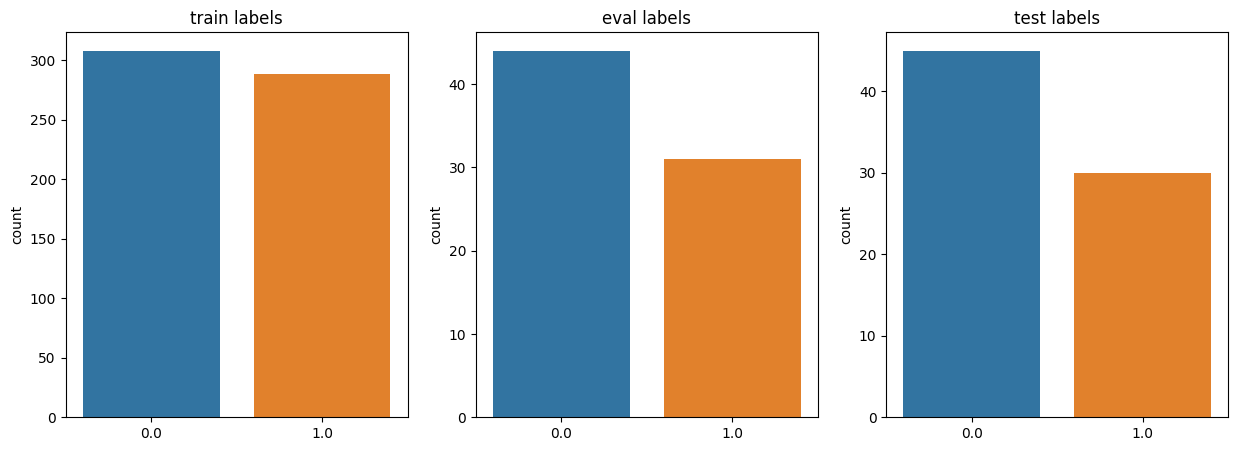

In [ ]:
plt.figure(1 , figsize = (15 ,5))
n = 0 
for z , j in zip([train_y , eval_y , test_y] , ['train labels','eval labels','test labels']):
    n += 1
    plt.subplot(1 , 3  , n)
    sns.countplot(x = z )
    plt.title(j)
plt.show()

In [ ]:
## Y데이터 one-hot-encoding
## Y데이터를 라벨의 개수에 따라서 0과1로 변환하여준다. covid와 noncovid로 구분 되어있기때문에 y데이터는 0과 1로 변환된다.
import keras
from keras.utils import np_utils
train_y=keras.utils.to_categorical(train_y,len(np.unique(labels)))
test_y=keras.utils.to_categorical(test_y,len(np.unique(labels)))
eval_y=keras.utils.to_categorical(eval_y,len(np.unique(labels)))

# IMAGE Augumentation
이미지 데이터 수가 부족하기 떄문에 ImageDataGenerator 를 이용하여 데이터에 변화를 줘서 더 다양한 데이터를 만들어낸다

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

## test 데이터의 경우에는 따로 변환 없이 사용
test_datagen = ImageDataGenerator(rescale = 1./255)


train_generator =train_datagen.flow(train_x, train_y, batch_size = 16, shuffle = False)

validation_generator=train_datagen.flow(eval_x,eval_y, batch_size = 16, shuffle = False)

test_generator = test_datagen.flow(test_x, test_y, batch_size = 16, shuffle = True)

# 모델 생성

In [ ]:
from keras import layers, models
from keras import Input
from keras.models import Model
from keras import optimizers, initializers, regularizers, metrics
from keras.callbacks import ModelCheckpoint

In [ ]:
from keras.layers import Dense
from keras.optimizers import Adam
from efficientnet.keras import EfficientNetB0
from efficientnet.keras import EfficientNetB3
from keras import applications
from keras import callbacks
from keras.models import Sequential

In [ ]:
# efficient_net = EfficientNetB3(
#     weights='imagenet',
#     input_shape=(32,32,3),
#     include_top=False,
#     pooling='max'
# )

# model = Sequential()
# model.add(efficient_net)
# model.add(Dense(units = 120, activation='relu'))
# model.add(Dense(units = 120, activation = 'relu'))
# model.add(Dense(units = 1, activation='sigmoid'))
# model.summary()

In [ ]:
# 모델 불러오기
conv_layers = EfficientNetB3(
    weights='imagenet',
    input_shape=(minh,minv,3),
    include_top=False,
    pooling='max'
)
conv_layers.summary()

# Convolution Layer를 학습되지 않도록 고정 
for layer in conv_layers.layers:
    layer.trainable = False


# 새로운 모델 생성하기
model = models.Sequential()

# VGG16모델의 Convolution Layer를 추가
model.add(conv_layers)
 
# 모델의 Fully Connected 부분을 재구성
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2, activation='softmax'))


Model: "efficientnet-b3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv (Conv2D)             (None, 112, 112, 40  1080        ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 stem_bn (BatchNormalization)   (None, 112, 112, 40  160         ['stem_conv[0][0]']              
                                )                                                   

In [ ]:
#model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
model.compile(loss='binary_crossentropy', optimizer=optimizers.SGD(lr=0.1, momentum=0.9, nesterov=True)
, metrics=['acc'])

In [ ]:
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras import backend as K
def scheduler(epoch): #overfitting 방지
    if epoch < 5:
        return 0.0001
    else:
        print(f"Learning rate reduced to {0.0001 * np.exp(0.5 * (5 - epoch))}")
        return 0.0001 * np.exp(0.5 * (5 - epoch))
    
custom_callback = LearningRateScheduler(scheduler)

In [ ]:
history = model.fit_generator(train_generator,
                   validation_data=validation_generator,
                   epochs=20,
                   steps_per_epoch=train_x.shape[0]/16,
                   callbacks=[custom_callback])


Epoch 1/20
37/37 [==============================] - 107s 3s/step - loss: 1.4902 - acc: 0.4950 - val_loss: 0.6567 - val_acc: 0.6800 - lr: 1.0000e-04
Epoch 2/20
37/37 [==============================] - 98s 3s/step - loss: 1.2835 - acc: 0.5168 - val_loss: 0.6151 - val_acc: 0.7200 - lr: 1.0000e-04
Epoch 3/20
37/37 [==============================] - 89s 2s/step - loss: 1.1111 - acc: 0.5822 - val_loss: 0.6098 - val_acc: 0.7333 - lr: 1.0000e-04
Epoch 4/20
37/37 [==============================] - 97s 3s/step - loss: 0.9684 - acc: 0.6258 - val_loss: 0.5656 - val_acc: 0.7333 - lr: 1.0000e-04
Epoch 5/20
37/37 [==============================] - 88s 2s/step - loss: 0.9442 - acc: 0.6275 - val_loss: 0.5758 - val_acc: 0.7467 - lr: 1.0000e-04
Learning rate reduced to 0.0001
Epoch 6/20
37/37 [==============================] - 98s 3s/step - loss: 0.9951 - acc: 0.5587 - val_loss: 0.5489 - val_acc: 0.7600 - lr: 1.0000e-04
Learning rate reduced to 6.065306597126335e-05
Epoch 7/20
37/37 [====================

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(1, len(acc) + 1)

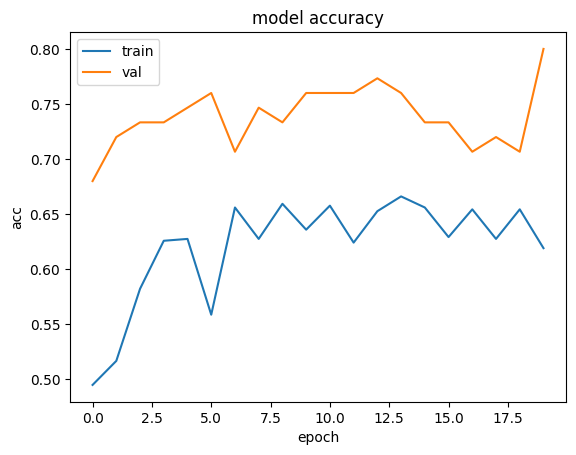

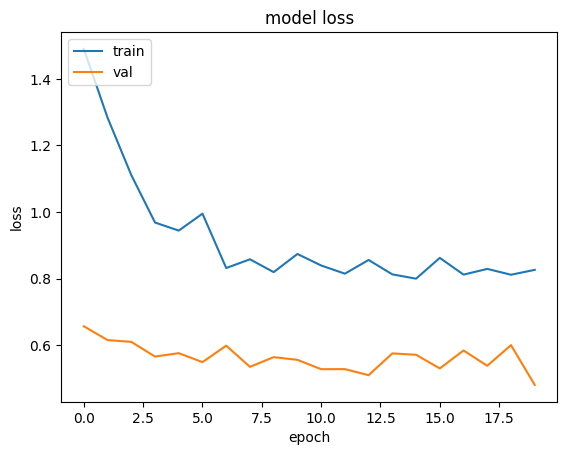

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()